# Summary
- This notebook is cloned from https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/notebook
- This notebook focused on hyperparameters tuning, rather than EDA/Feature Engineering
- It shows averaging models and/or stacking models could have better performance
- It's quite frustrating that even my local cv score (BOTH MEAN & STD) is better than serigne's, the Leader Board score is worse. No convincing points to explain this... 
- Serigne's LB score is 0.11470, my tuned version is 0.11728

# EDA / Data Visualization / Data Processing / Feature Engineering

In [1]:
#import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore') #Supress unnecessary warnings for readability

from scipy import stats
from scipy.stats import norm, skew #for some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

data_description.txt
sample_submission.csv
test.csv
train.csv



In [2]:
#Now let's import and put the train and test datasets in  pandas dataframe

train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
##display the first five rows of the train dataset.
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
##display the first five rows of the test dataset.
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


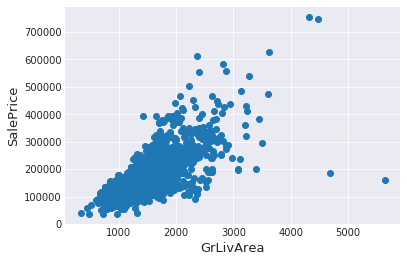

In [6]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

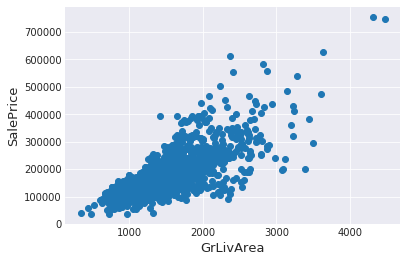

In [7]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()


 mu = 180932.92 and sigma = 79467.79



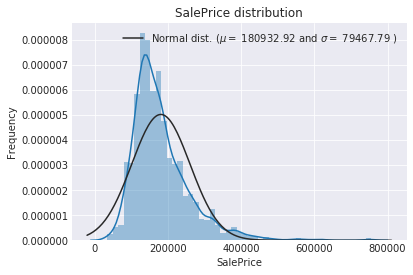

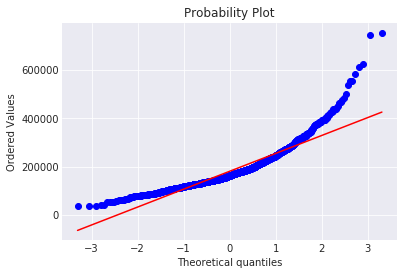

In [8]:
sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()


 mu = 12.02 and sigma = 0.40



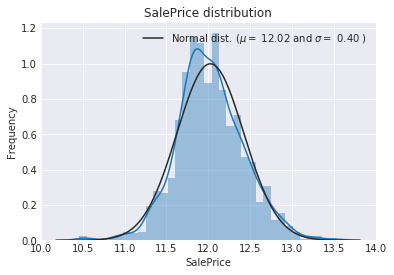

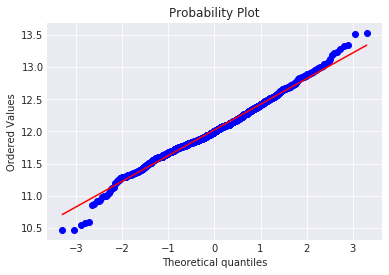

In [9]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

#Check the new distribution 

sns.distplot(train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


In [11]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)


,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


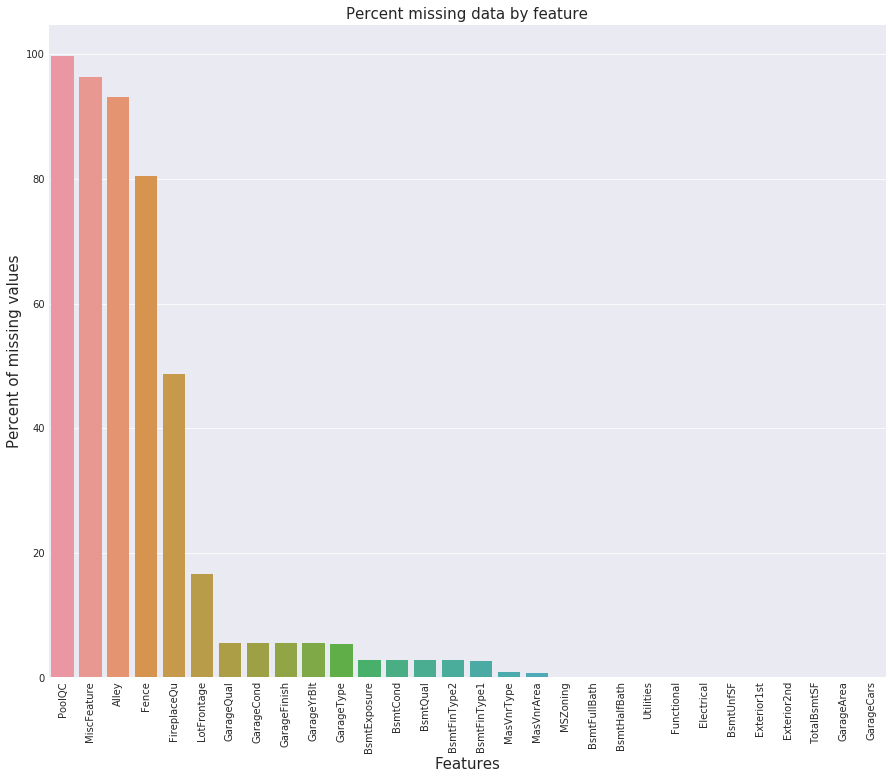

In [12]:
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

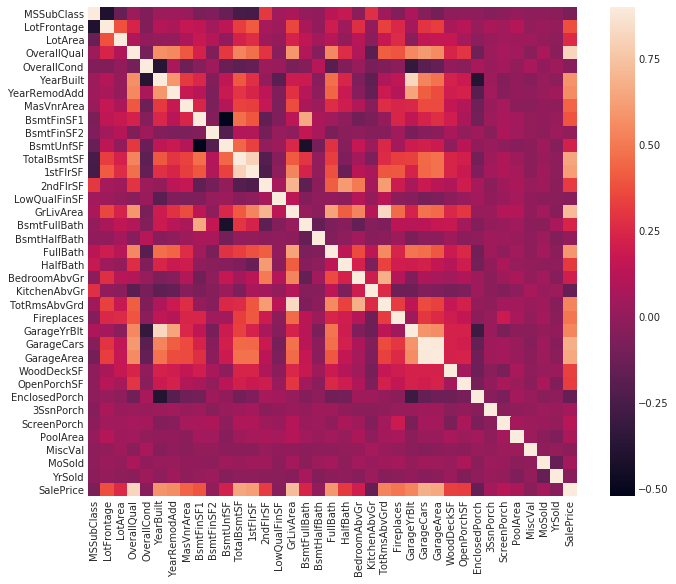

In [13]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [14]:
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)    
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data = all_data.drop(['Utilities'], axis=1)
all_data["Functional"] = all_data["Functional"].fillna("Typ")
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")


In [15]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [16]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)


#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)


#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)


In [17]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


In [18]:
# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [19]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


In [20]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
    all_data[feat] += 1
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


In [21]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [22]:
train = all_data[:ntrain]
test = all_data[ntrain:]

# Modelling

In [23]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost.sklearn import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor


KFOLD = 5
RANDOM_SEED = 1
RANDOM_SEED2 = 42
RANDOM_SEED3 = 99

# Helper for cross_validataion evaluation
import math

# Note: Seems that n_jobs = -1 will hang for xgboost
def compute_cv_score(estimator, X, y, scoring='neg_mean_squared_error', parallel_model=False, seed=RANDOM_SEED):
    kf = KFold(n_splits=KFOLD, shuffle=True, random_state=seed)
    n_jobs = 1 if parallel_model else -1
    xval = cross_val_score(estimator, X, y, cv=kf, scoring=scoring, n_jobs=n_jobs)
    rmse= np.sqrt(-xval)
    print('  CV Score : RMSE - %.5f (+/- %.5f) \n' % (np.mean(rmse), np.std(rmse)))
    return rmse
   
    
# Helper for choosing best GridSearchCV model
def get_best_cv_model(estimator, X, y, parameter_grid, scoring='neg_mean_squared_error', parallel_model=False, seed=RANDOM_SEED, show=False):
    kf = KFold(n_splits=KFOLD, shuffle=True, random_state=seed)
    n_jobs = 1 if parallel_model else -1
    print('n_jobs = ', n_jobs)
    regr = GridSearchCV(estimator,
                        param_grid=parameter_grid,
                        cv=kf,
                        scoring=scoring,
                        n_jobs=n_jobs)
    
    regr.fit(X, y)

    train_mean_of_choice = regr.cv_results_['mean_train_score'][regr.best_index_]
    train_std_of_choice = regr.cv_results_['std_train_score'][regr.best_index_]
    test_mean_of_choice = regr.cv_results_['mean_test_score'][regr.best_index_]
    test_std_of_choice = regr.cv_results_['std_test_score'][regr.best_index_]
    
    print('  KFold: %d' % regr.n_splits_)
    print('  Best score: {}'.format(math.sqrt(abs(regr.best_score_))))
    print('  Best parameters: {}'.format(regr.best_params_))
    print("  [train:%0.5f (+/- %.5f) & test:%0.5f (+/- %.5f) of best model]" % 
          (train_mean_of_choice, train_std_of_choice, test_mean_of_choice, test_std_of_choice))
    
    if show:
        train_mses = abs(regr.cv_results_['mean_train_score'])
        train_rmses = [math.sqrt(m) for m in train_mses]
        test_mses = abs(regr.cv_results_['mean_test_score'])
        test_rmses = [math.sqrt(m) for m in test_mses]
        for train_rmse, test_rmse, params in zip(train_rmses, test_rmses, regr.cv_results_['params']):
            print("  [train:%0.5f & test:%0.5f for %r]" % (train_rmse, test_rmse, params))    
    return regr.best_estimator_
    
    
# Helper for plotting xgboost learning curves
def plot_learning_curve(booster, X, y, kfold=KFOLD, seed=RANDOM_SEED):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=seed)

    for train_index, test_index in kf.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        booster.fit(X_train, 
                    y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    early_stopping_rounds=50,
                    verbose=False)
        evals_result = booster.evals_result()
        epochs = len(evals_result['validation_0']['rmse'])
        x_axis = range(0, epochs)
        fig, ax = plt.subplots()
        ax.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
        ax.plot(x_axis, evals_result['validation_1']['rmse'], label='Test')
        ax.legend()
        plt.ylim([0, 1])
        plt.ylabel('RMSE Loss')
        plt.title('XGBoost RMSE Loss')
        plt.show()   

/home/winston/.pyenv/versions/3.5.2/envs/tf-p35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## (1) XGBoost

### According to Owen Zhang at ODSC Boston 2015, he tunes XGBoost as below
- eta (learning rate) + num_round (number of trees)
  - Examine objective metric in training/validation to quickly find good configuration
  - Target around 100 trees
- max_depth (start with 6)
- min_child_weight (start with 1/sqrt(event rate)) <-- don't understand, use 1,3,5,7 per other tuning guides
- colsample_bytree (.3-.5)
- subsampling (leave at 1.0)
- gamma (usually OK to leave at 0.0)

#### Tuning heuristics via learning curve
(1) Too complex: (training loss decrease, validation loss decrease->increase)
    - reduce eta, max_depth
    - increase min_child_weight
(2) Just Right: (training loss & validation loss decrease, validataion loss flatten then)
    
(3) Too simple: (both training & validation decrease)
    - increase eta, max_depth
    - reduce min_child_weight

### Other tuning guides:
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://www.linkedin.com/pulse/approaching-almost-any-machine-learning-problem-abhishek-thakur/

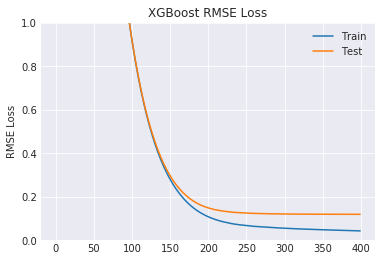

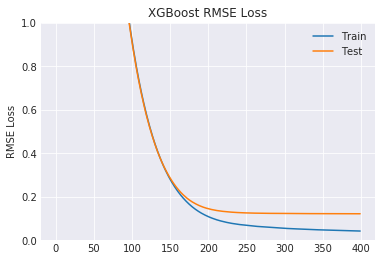

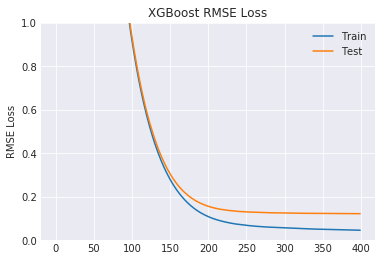

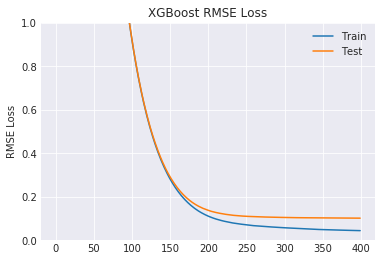

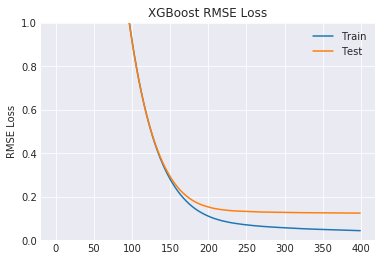

  CV Score : RMSE - 0.11814 (+/- 0.00835) 

  CV Score : RMSE - 0.12091 (+/- 0.00845) 

  CV Score : RMSE - 0.12064 (+/- 0.00605) 



In [27]:
## (1) Try to get the good configuration of learning_rate + n_estimators
xgb = XGBRegressor(learning_rate=0.025,
                   n_estimators=400,
                   max_depth=6,
                   min_child_weight=1,
                   gamma=0,
                   subsample=1.0,
                   colsample_bytree=0.5,
                   nthread=-1,
                   seed=RANDOM_SEED)

plot_learning_curve(xgb, train.values, y_train)
compute_cv_score(xgb, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(xgb, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(xgb, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)

In [28]:
# (2) Tune max_depth & min_child_weight

parameter_grid = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10], # 3 ~ 10
    'min_child_weight': [1, 3, 5, 7],
    'colsample_bytree': [0.3, 0.4, 0.5]
}

xgb1 = get_best_cv_model(xgb, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED)
xgb2 = get_best_cv_model(xgb, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED2)
xgb3 = get_best_cv_model(xgb, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED3)


n_jobs =  1
  KFold: 5
  Best score: 0.1155171328314853
  Best parameters: {'max_depth': 5, 'min_child_weight': 3, 'colsample_bytree': 0.3}
  [train:-0.00366 (+/- 0.00017) & test:-0.01334 (+/- 0.00202) of best model]
n_jobs =  1
  KFold: 5
  Best score: 0.117640889242129
  Best parameters: {'max_depth': 7, 'min_child_weight': 3, 'colsample_bytree': 0.3}
  [train:-0.00160 (+/- 0.00012) & test:-0.01384 (+/- 0.00168) of best model]
n_jobs =  1
  KFold: 5
  Best score: 0.1185241133613057
  Best parameters: {'max_depth': 8, 'min_child_weight': 7, 'colsample_bytree': 0.3}
  [train:-0.00191 (+/- 0.00011) & test:-0.01405 (+/- 0.00179) of best model]


In [38]:
from sklearn.base import clone

xgb_ = clone(xgb)

xgb_.set_params(max_depth=5)
xgb_.set_params(min_child_weight=3)
xgb_.set_params(colsample_bytree=0.3)
print('1st set parameters cv\n')
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)

xgb_.set_params(max_depth=7)
xgb_.set_params(min_child_weight=3)
xgb_.set_params(colsample_bytree=0.3)
print('2nd set parameters cv\n')
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)

xgb_.set_params(max_depth=8)
xgb_.set_params(min_child_weight=7)
xgb_.set_params(colsample_bytree=0.3)
print('3rd set parameters cv\n')
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)



1st set parameters cv

  CV Score : RMSE - 0.11513 (+/- 0.00932) 

  CV Score : RMSE - 0.11819 (+/- 0.00741) 

  CV Score : RMSE - 0.11956 (+/- 0.00727) 

2nd set parameters cv

  CV Score : RMSE - 0.11564 (+/- 0.00859) 

  CV Score : RMSE - 0.11741 (+/- 0.00728) 

  CV Score : RMSE - 0.11959 (+/- 0.00668) 

3rd set parameters cv

  CV Score : RMSE - 0.11580 (+/- 0.00890) 

  CV Score : RMSE - 0.11777 (+/- 0.00788) 

  CV Score : RMSE - 0.11829 (+/- 0.00754) 



- 2nd set parameters are generally better in terms of mean & std

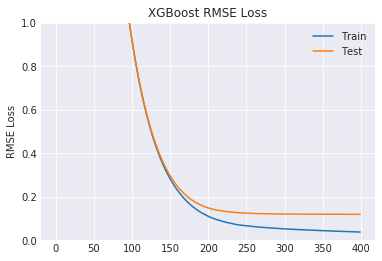

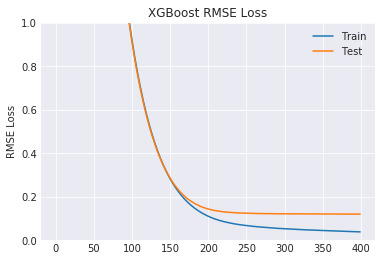

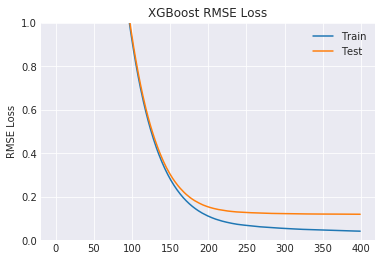

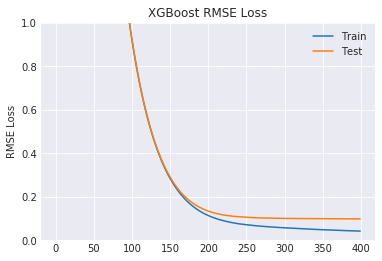

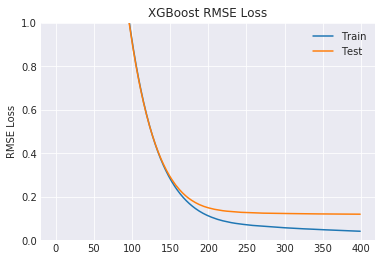

In [40]:
plot_learning_curve(xgb2, train.values, y_train)

- Seems OK (e.g. it keeps improving until 400 iterations), try increase n_estimators to see if it can further reduce cv score

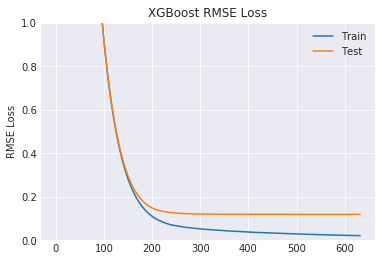

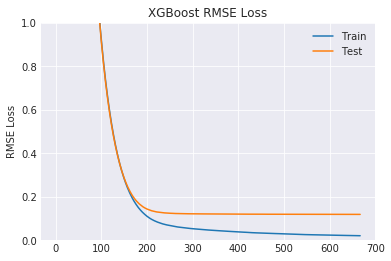

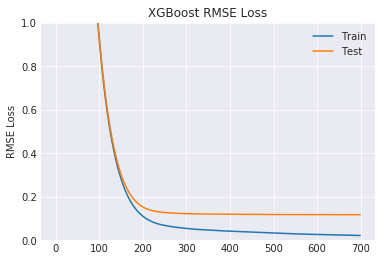

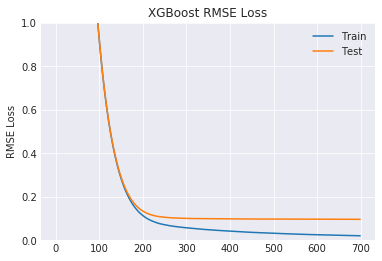

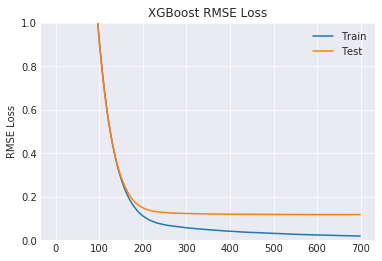

In [43]:
xgb_ = clone(xgb2)
xgb_.set_params(n_estimators=700)
plot_learning_curve(xgb_, train.values, y_train)

In [53]:
rmse1 = compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
rmse2 = compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(xgb_, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.11409 (+/- 0.00880) 

  CV Score : RMSE - 0.11634 (+/- 0.00741) 

  CV Score : RMSE - 0.11814 (+/- 0.00649) 

average rmse: 0.11619 (+/- 0.00757)


In [45]:
xgb = clone(xgb_)
xgb

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.025, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=700, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1.0)

In [24]:
xgb = XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.025, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=700, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1.0)

## (2) Gradient Boosting Regressor

- Follow Owen Zhang's tuning heuristic on Gradient Boosting:
    - trees : fixed value (100-1000)
    - learning rate: fixed -> fine tune, [2-10]/trees
    - row sampling: gridsearch [.5, .75, 1.0]
    - column sampling: gridsearch [.4, .6, .8, 1.0]
    - min leaf weight: fixed -> fine tune, 3 / (% of rare events)? <-- don't understand, use 1,3,5,7 instead
    - max tree depth: gridsearch, [4,6,8,10]
    - min split gain: fixed 0, keep it 0


In [57]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(learning_rate=10./400,
                                n_estimators=400,
                                max_depth=6,
                                subsample=0.5,
                                max_features = 'sqrt',
                                min_samples_leaf=1,
                                random_state=RANDOM_SEED)

compute_cv_score(gbr, train.values, y_train, scoring='neg_mean_squared_error')

  CV Score : RMSE - 0.11623 (+/- 0.00856) 



array([ 0.11845833,  0.12084745,  0.11413012,  0.10112855,  0.12658535])

In [58]:
parameter_grid = {
    'max_depth': [4, 6, 8, 10],
    'subsample': [.5, .75, 1.0],
    'max_features': ['sqrt', .4, .6, .8, 1.0],
    'min_samples_leaf': [1, 3, 5, 7]
}


gbr1 = get_best_cv_model(gbr, train.values, y_train, parameter_grid, seed=RANDOM_SEED)
gbr2 = get_best_cv_model(gbr, train.values, y_train, parameter_grid, seed=RANDOM_SEED2)
gbr3 = get_best_cv_model(gbr, train.values, y_train, parameter_grid, seed=RANDOM_SEED3)


n_jobs =  -1
  KFold: 5
  Best score: 0.11303165765128874
  Best parameters: {'max_depth': 4, 'min_samples_leaf': 1, 'max_features': 0.4, 'subsample': 0.5}
  [train:-0.00345 (+/- 0.00012) & test:-0.01278 (+/- 0.00180) of best model]
n_jobs =  -1
  KFold: 5
  Best score: 0.11451289739058922
  Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'subsample': 0.75}
  [train:-0.00529 (+/- 0.00018) & test:-0.01311 (+/- 0.00160) of best model]
n_jobs =  -1
  KFold: 5
  Best score: 0.11512045931237454
  Best parameters: {'max_depth': 4, 'min_samples_leaf': 3, 'max_features': 0.4, 'subsample': 0.5}
  [train:-0.00392 (+/- 0.00008) & test:-0.01325 (+/- 0.00150) of best model]


In [59]:
gbr_ = clone(gbr)

gbr_.set_params(max_depth=4)
gbr_.set_params(min_samples_leaf=1)
gbr_.set_params(max_features=0.4)
gbr_.set_params(subsample=0.5)
print('1st set parameters cv\n')
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED2)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED3)

gbr_.set_params(max_depth=4)
gbr_.set_params(min_samples_leaf=3)
gbr_.set_params(max_features='sqrt')
gbr_.set_params(subsample=0.75)
print('2nd set parameters cv\n')
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED2)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED3)

gbr_.set_params(max_depth=4)
gbr_.set_params(min_samples_leaf=3)
gbr_.set_params(max_features=0.4)
gbr_.set_params(subsample=0.5)
print('3rd set parameters cv\n')
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED2)
compute_cv_score(gbr_, train.values, y_train, scoring='neg_mean_squared_error', seed=RANDOM_SEED3)


1st set parameters cv

  CV Score : RMSE - 0.11271 (+/- 0.00843) 

  CV Score : RMSE - 0.11437 (+/- 0.00738) 

  CV Score : RMSE - 0.11504 (+/- 0.00498) 

2nd set parameters cv

  CV Score : RMSE - 0.11469 (+/- 0.00907) 

  CV Score : RMSE - 0.11428 (+/- 0.00721) 

  CV Score : RMSE - 0.11749 (+/- 0.00582) 

3rd set parameters cv

  CV Score : RMSE - 0.11296 (+/- 0.00878) 

  CV Score : RMSE - 0.11453 (+/- 0.00625) 

  CV Score : RMSE - 0.11494 (+/- 0.00640) 



array([ 0.1260693 ,  0.10757471,  0.11278318,  0.11733824,  0.1109416 ])

- 1st set parameters are generally better in terms of mean & std

In [63]:
from sklearn.base import clone

parameter_grid = {
    'n_estimators': [400, 450, 500, 550, 600, 650, 700, 750, 800],
}

gbr_ = clone(gbr1)
gbr_ = get_best_cv_model(gbr_, train.values, y_train, parameter_grid, show=True)

n_jobs =  -1
  KFold: 5
  Best score: 0.11222054484626491
  Best parameters: {'n_estimators': 700}
  [train:-0.00191 (+/- 0.00007) & test:-0.01259 (+/- 0.00182) of best model]
  [train:0.05872 & test:0.11303 for {'n_estimators': 400}]
  [train:0.05565 & test:0.11283 for {'n_estimators': 450}]
  [train:0.05286 & test:0.11263 for {'n_estimators': 500}]
  [train:0.05039 & test:0.11243 for {'n_estimators': 550}]
  [train:0.04800 & test:0.11229 for {'n_estimators': 600}]
  [train:0.04578 & test:0.11231 for {'n_estimators': 650}]
  [train:0.04371 & test:0.11222 for {'n_estimators': 700}]
  [train:0.04181 & test:0.11222 for {'n_estimators': 750}]
  [train:0.03992 & test:0.11227 for {'n_estimators': 800}]


In [64]:
rmse1 = compute_cv_score(gbr_, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(gbr_, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(gbr_, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.11188 (+/- 0.00863) 

  CV Score : RMSE - 0.11308 (+/- 0.00752) 

  CV Score : RMSE - 0.11365 (+/- 0.00510) 

average rmse: 0.11287 (+/- 0.00708)


In [65]:
gbr = clone(gbr_)
gbr

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.025, loss='ls', max_depth=4, max_features=0.4,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=700,
             presort='auto', random_state=1, subsample=0.5, verbose=0,
             warm_start=False)

In [25]:
gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.025, loss='ls', max_depth=4, max_features=0.4,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=700,
             presort='auto', random_state=1, subsample=0.5, verbose=0,
             warm_start=False)

## (3) LightGBM

In [28]:
# Helper for plotting lightgbm learning curves, similar to xgboost's but slightly different APIs for sklearn's fit
def plot_learning_curve2(booster, X, y, kfold=KFOLD, seed=RANDOM_SEED):
    kf = KFold(n_splits=kfold, shuffle=True, random_state=seed)

    for train_index, test_index in kf.split(X, y):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        eval_set = [(X_train, y_train), (X_test, y_test)]
        evals_result = {}
        booster.fit(X_train, 
                    y_train, 
                    eval_set=eval_set,
                    eval_metric='rmse',
                    eval_names=['train', 'test'],
                    early_stopping_rounds=50,
                    verbose=False, callbacks=[lightgbm.callback.record_evaluation(evals_result)])
  
        epochs = len(evals_result['train']['rmse'])
        x_axis = range(0, epochs)
        fig, ax = plt.subplots()
        ax.plot(x_axis, evals_result['train']['rmse'], label='Train')
        ax.plot(x_axis, evals_result['test']['rmse'], label='Test')
        ax.legend()
        plt.ylim([0, 0.5])
        plt.ylabel('RMSE Loss')
        plt.title('XGBoost RMSE Loss')
        plt.show()   

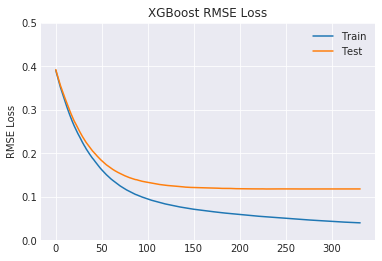

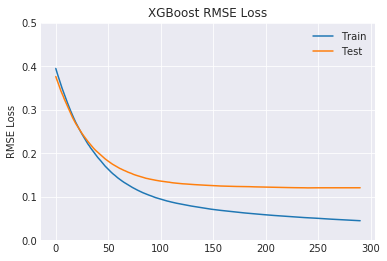

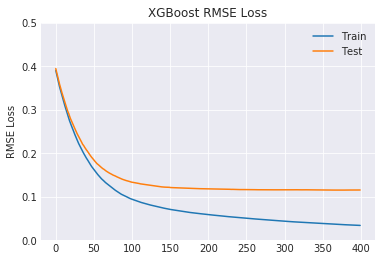

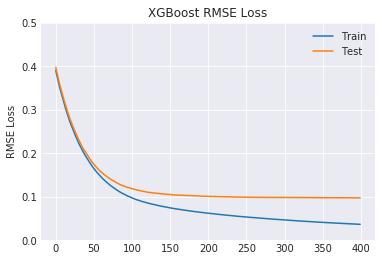

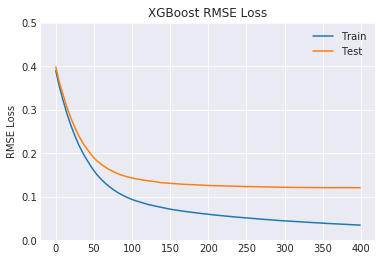

  CV Score : RMSE - 0.11470 (+/- 0.00878) 

  CV Score : RMSE - 0.11529 (+/- 0.00702) 

  CV Score : RMSE - 0.11630 (+/- 0.00522) 



array([ 0.12584095,  0.11317257,  0.11233481,  0.11797417,  0.11218633])

In [29]:
import lightgbm

lgbm = lightgbm.LGBMRegressor(objective='regression',
                              learning_rate=0.025, n_estimators=400,
                              num_leaves=31, min_child_samples=5,
                              colsample_bytree=0.3, subsample=0.5,
                              seed=RANDOM_SEED)

plot_learning_curve2(lgbm, train.values, y_train)
compute_cv_score(lgbm, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(lgbm, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(lgbm, train.values, y_train, scoring='neg_mean_squared_error', parallel_model=True, seed=RANDOM_SEED3)

In [ ]:
parameter_grid = {
    'min_child_samples': [1, 3, 5, 7],
    'colsample_bytree': [0.3, 0.4, 0.5],
    'subsample': [0.5, 0.75, 1.0]
}

lgbm1 = get_best_cv_model(lgbm, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED)
lgbm2 = get_best_cv_model(lgbm, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED2)
lgbm3 = get_best_cv_model(lgbm, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED3)


n_jobs =  1
  KFold: 5
  Best score: 0.1150412970458694
  Best parameters: {'min_child_samples': 1, 'subsample': 0.5, 'colsample_bytree': 0.3}
  [train:-0.00121 (+/- 0.00008) & test:-0.01323 (+/- 0.00191) of best model]
n_jobs =  1
  KFold: 5
  Best score: 0.11550464382324939
  Best parameters: {'min_child_samples': 1, 'subsample': 0.5, 'colsample_bytree': 0.3}
  [train:-0.00118 (+/- 0.00003) & test:-0.01334 (+/- 0.00161) of best model]
n_jobs =  1


In [30]:
parameter_grid = {
    'min_child_samples': [1, 3, 5, 7],
    'colsample_bytree': [0.3, 0.4, 0.5],
    'subsample': [0.5, 0.75, 1.0]
}

lgbm3 = get_best_cv_model(lgbm, train.values, y_train, parameter_grid, parallel_model=True, seed=RANDOM_SEED3)

n_jobs =  1
  KFold: 5
  Best score: 0.11642064140054835
  Best parameters: {'colsample_bytree': 0.3, 'subsample': 0.5, 'min_child_samples': 1}
  [train:-0.00121 (+/- 0.00004) & test:-0.01355 (+/- 0.00124) of best model]


- It is not stable for running lightGBM on my machine (crashed python kernel from time to time), so here I just separated them into different cells to resume. 
- All three random shuffled datasets lead to same parameters

In [33]:
from sklearn.base import clone

lgbm_ = clone(lgbm)

lgbm_.set_params(min_child_samples=1)
lgbm_.set_params(colsample_bytree=0.3)
lgbm_.set_params(subsample=0.5)
compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED)
compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED2)
compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED3)


  CV Score : RMSE - 0.11470 (+/- 0.00878) 

  CV Score : RMSE - 0.11529 (+/- 0.00702) 

  CV Score : RMSE - 0.11630 (+/- 0.00522) 



array([ 0.12584095,  0.11317257,  0.11233481,  0.11797417,  0.11218633])

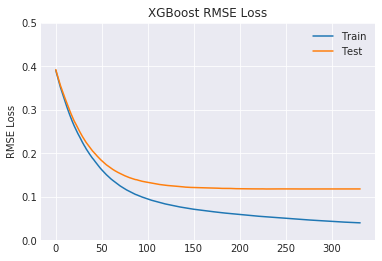

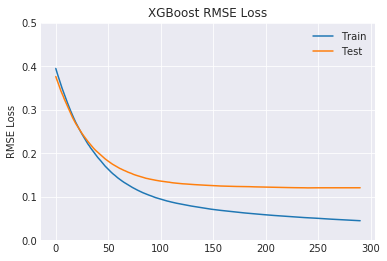

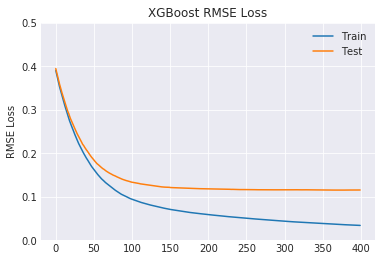

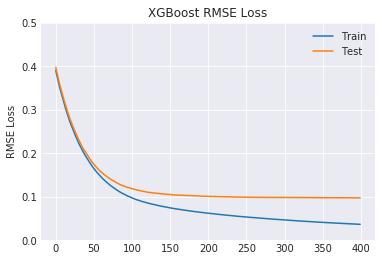

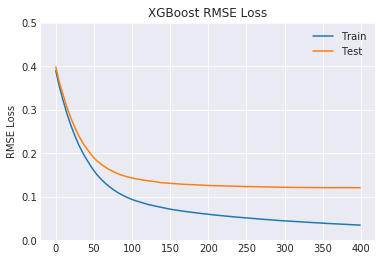

In [34]:
plot_learning_curve2(lgbm_, train.values, y_train)

- Learning curve showed it might stop improving before 400 iterations (e.g. n_estimators), we use 400 as n_estimators.
- Some quick experiments with more n_estimatiors showed no improvement.

In [35]:
rmse1 = compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED)
rmse2 = compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(lgbm_, train.values, y_train, parallel_model=True, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.11470 (+/- 0.00878) 

  CV Score : RMSE - 0.11529 (+/- 0.00702) 

  CV Score : RMSE - 0.11630 (+/- 0.00522) 

average rmse: 0.11543 (+/- 0.00701)


In [36]:
lgbm = clone(lgbm_)
lgbm

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.3, learning_rate=0.025,
       max_bin=255, max_depth=-1, min_child_samples=1, min_child_weight=5,
       min_split_gain=0, n_estimators=400, nthread=-1, num_leaves=31,
       objective='regression', reg_alpha=0, reg_lambda=0, seed=1,
       silent=True, subsample=0.5, subsample_for_bin=50000,
       subsample_freq=1)

## (4) Lasso, ENet, KRR

In [39]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)


In [40]:
rmse1 = compute_cv_score(lasso, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(lasso, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(lasso, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('Lasso: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

rmse1 = compute_cv_score(ENet, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(ENet, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(ENet, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('ENet: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

rmse1 = compute_cv_score(KRR, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(KRR, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(KRR, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('KRR: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.11188 (+/- 0.00826) 

  CV Score : RMSE - 0.11234 (+/- 0.00797) 

  CV Score : RMSE - 0.11126 (+/- 0.00509) 

Lasso: average rmse: 0.11182 (+/- 0.00711)
  CV Score : RMSE - 0.11178 (+/- 0.00815) 

  CV Score : RMSE - 0.11240 (+/- 0.00805) 

  CV Score : RMSE - 0.11108 (+/- 0.00514) 

ENet: average rmse: 0.11175 (+/- 0.00711)
  CV Score : RMSE - 0.11387 (+/- 0.00867) 

  CV Score : RMSE - 0.11569 (+/- 0.00799) 

  CV Score : RMSE - 0.11323 (+/- 0.00572) 

KRR: average rmse: 0.11427 (+/- 0.00746)


## Ensemble/Averaging

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [42]:
averaged_models = AveragingModels(models = (ENet, gbr, KRR, lasso))

rmse1 = compute_cv_score(averaged_models, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(averaged_models, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(averaged_models, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('averaged_models: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.10782 (+/- 0.00849) 

  CV Score : RMSE - 0.10875 (+/- 0.00800) 

  CV Score : RMSE - 0.10764 (+/- 0.00518) 

averaged_models: average rmse: 0.10807 (+/- 0.00723)


## Ensemble/Stacking
## Illustration ![](http://7xlo8f.com1.z0.glb.clouddn.com/blog-diagram-stacking.jpg)

In [43]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(clf)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [44]:
stacked_models = StackingAveragedModels(base_models = (ENet, gbr, KRR), meta_model = lasso)

rmse1 = compute_cv_score(stacked_models, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(stacked_models, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(stacked_models, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('stacked_models: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.10757 (+/- 0.00813) 

  CV Score : RMSE - 0.10852 (+/- 0.00811) 

  CV Score : RMSE - 0.10727 (+/- 0.00551) 

stacked_models: average rmse: 0.10779 (+/- 0.00725)


# Compare with Serigne's models

In [46]:
# Check Serigne's GBoost, XGBoost, lightGBM models
from sklearn.ensemble import GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
import xgboost 
import lightgbm


GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.2, gamma=0.0, 
                                 learning_rate=0.05, max_depth=6, 
                                 min_child_weight=1.5, n_estimators=7200,
                                 reg_alpha=0.9, reg_lambda=0.6,
                                 subsample=0.2,seed=42, silent=1)
model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                                  learning_rate=0.05, n_estimators=720,
                                  max_bin = 55, bagging_fraction = 0.8,
                                  bagging_freq = 5, feature_fraction = 0.2319,
                                  feature_fraction_seed=9, bagging_seed=9,
                                  min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [48]:
rmse1 = compute_cv_score(GBoost, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(GBoost, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(GBoost, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('GBoost: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

rmse1 = compute_cv_score(model_xgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED)
rmse2 = compute_cv_score(model_xgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(model_xgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('model_xgb: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

rmse1 = compute_cv_score(model_lgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED)
rmse2 = compute_cv_score(model_lgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(model_lgb, train.values, y_train, parallel_model=True, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('model_lgb: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.11595 (+/- 0.00887) 

  CV Score : RMSE - 0.11659 (+/- 0.00931) 

  CV Score : RMSE - 0.11595 (+/- 0.00502) 

GBoost: average rmse: 0.11616 (+/- 0.00773)
  CV Score : RMSE - 0.11771 (+/- 0.00876) 

  CV Score : RMSE - 0.11929 (+/- 0.00856) 

  CV Score : RMSE - 0.12055 (+/- 0.00514) 

model_xgb: average rmse: 0.11918 (+/- 0.00748)
  CV Score : RMSE - 0.11551 (+/- 0.00828) 

  CV Score : RMSE - 0.11690 (+/- 0.00988) 

  CV Score : RMSE - 0.11621 (+/- 0.00543) 

model_lgb: average rmse: 0.11621 (+/- 0.00786)


In [49]:
averaged_models2 = AveragingModels(models = (ENet, GBoost, KRR, lasso))

rmse1 = compute_cv_score(averaged_models2, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(averaged_models2, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(averaged_models2, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('averaged_models 2: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.10845 (+/- 0.00859) 

  CV Score : RMSE - 0.10922 (+/- 0.00886) 

  CV Score : RMSE - 0.10788 (+/- 0.00505) 

averaged_models 2: average rmse: 0.10852 (+/- 0.00750)


In [50]:
stacked_models2 = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)

rmse1 = compute_cv_score(stacked_models2, train.values, y_train, seed=RANDOM_SEED)
rmse2 = compute_cv_score(stacked_models2, train.values, y_train, seed=RANDOM_SEED2)
rmse3 = compute_cv_score(stacked_models2, train.values, y_train, seed=RANDOM_SEED3)
mean_ = (rmse1.mean() + rmse2.mean() + rmse3.mean()) / 3
std_ = (rmse1.std() + rmse2.std() + rmse3.std()) / 3
print('stacked_models 2: average rmse: %.5f (+/- %.5f)' % (mean_, std_))

  CV Score : RMSE - 0.10827 (+/- 0.00841) 

  CV Score : RMSE - 0.10895 (+/- 0.00846) 

  CV Score : RMSE - 0.10749 (+/- 0.00497) 

stacked_models 2: average rmse: 0.10824 (+/- 0.00728)


## Summary
## Local CV comparison of Serigne's & my tuned models

## (1) Common models CV scores:
- Lasso: 0.11182 (+/- 0.00711)
- ENet:  0.11175 (+/- 0.00711)
- KRR:   0.11427 (+/- 0.00746)

## (2) My tuned models CV scores:
- GBR:   0.11287 (+/- 0.00708)
- XGB:   0.11619 (+/- 0.00757)
- LGBM:  0.11543 (+/- 0.00701)
- AVG(ENet, GBR, KRR, Lasso): 0.10807 (+/- 0.00723)
- STACK(ENet, GBR, KRR -> Lasso): 0.10779 (+/- 0.00725)

## (3) Serigne tuned models CV scores:
- GBR:   0.11616 (+/- 0.00773)
- XGB:   0.11918 (+/- 0.00748)
- LGBM:  0.11621 (+/- 0.00786)
- AVG(ENet, GBR, KRR, Lasso): 0.10852 (+/- 0.00750)
- STACK(ENet, GBR, KRR -> Lasso): 0.10824 (+/- 0.00728)

# Output Predictions

In [51]:
from sklearn.metrics import mean_squared_error

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_models.fit(train.values, y_train)
stacked_train_pred = stacked_models.predict(train.values)
stacked_pred = np.expm1(stacked_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

stacked_models2.fit(train.values, y_train)
stacked_train_pred2 = stacked_models2.predict(train.values)
stacked_pred2 = np.expm1(stacked_models2.predict(test.values))
print(rmsle(y_train, stacked_train_pred2))


0.0770335136934
0.0754760684015


In [53]:
xgb.fit(train, y_train)
xgb_train_pred = xgb.predict(train)
xgb_pred = np.expm1(xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

model_xgb.fit(train, y_train)
model_xgb_train_pred = model_xgb.predict(train)
model_xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, model_xgb_train_pred))

0.0239990209739
0.0424478807878


In [54]:
lgbm.fit(train, y_train)
lgbm_train_pred = lgbm.predict(train)
lgbm_pred = np.expm1(lgbm.predict(test.values))
print(rmsle(y_train, lgbm_train_pred))

model_lgb.fit(train, y_train)
model_lgb_train_pred = model_lgb.predict(train)
model_lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, model_lgb_train_pred))

0.0393929465217
0.0725150427394


In [56]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train, stacked_train_pred*0.70 +
               xgb_train_pred*0.10 + lgbm_train_pred*0.20 ))
print(rmsle(y_train, stacked_train_pred2*0.70 +
               model_xgb_train_pred*0.10 + model_lgb_train_pred*0.20 ))

RMSLE score on train data:
0.0628163166018
0.0697664006313


In [57]:
ensemble = stacked_pred*0.70 + xgb_pred*0.10 + lgbm_pred*0.20
ensemble2 = stacked_pred2*0.70 + model_xgb_pred*0.10 + model_lgb_pred*0.20

In [58]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('serigne+mine.csv',index=False)

In [59]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble2
sub.to_csv('serigne.csv',index=False)

- The submission score of ensemble is 0.11728 (Serigne's models)
- The submission score of ensemble2 is 0.11470 (My tuned models: XGB, GBR, LGBM)